In [32]:
# Loading libraries set 
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [33]:
# Loading datasets
df_client_profiles = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/df_final.csv")
df_experiment_clients = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/exp.csv")
df_web_data_1 = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/data_1.csv")
df_web_data_2 = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/data_2.csv")


In [34]:
# Display the first few rows of each dataframe to understand their structure
print("Client Profiles DataFrame:")
print(df_client_profiles.head())

print("\nWeb Data Part 1 DataFrame:")
print(df_web_data_1.head())

print("\nWeb Data Part 2 DataFrame:")
print(df_web_data_2.head())

print("\nExperiment Clients DataFrame:")
print(df_experiment_clients.head())

Client Profiles DataFrame:
   client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
0     836976             6.0              73.0      60.5     U        2.0   
1    2304905             7.0              94.0      58.0     U        2.0   
2    1439522             5.0              64.0      32.0     U        2.0   
3    1562045            16.0             198.0      49.0     M        2.0   
4    5126305            12.0             145.0      33.0     F        2.0   

         bal  calls_6_mnth  logons_6_mnth  
0   45105.30           6.0            9.0  
1  110860.30           6.0            9.0  
2   52467.79           6.0            9.0  
3   67454.65           3.0            6.0  
4  103671.75           0.0            3.0  

Web Data Part 1 DataFrame:
   client_id            visitor_id                      visit_id process_step  \
0    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
1    9988021  580560515_7732621733  781255054_2193545317

In [35]:
# Merge web data parts
df_web_data = pd.concat([df_web_data_1, df_web_data_2])

# Check for missing values
print("Missing values in Client Profiles DataFrame:")
print(df_client_profiles.isnull().sum())

print("\nMissing values in Web Data DataFrame:")
print(df_web_data.isnull().sum())

print("\nMissing values in Experiment Clients DataFrame:")
print(df_experiment_clients.isnull().sum())

# Handle missing values (if any)
df_client_profiles.dropna(inplace=True)
df_web_data.dropna(inplace=True)
df_experiment_clients.dropna(inplace=True)

# Rename 'Variation' to 'experiment_group'
df_experiment_clients.rename(columns={'Variation': 'experiment_group'}, inplace=True)

# Merge datasets
df_merged = df_web_data.merge(df_experiment_clients, on='client_id').merge(df_client_profiles, on='client_id')

# Print columns of merged dataframe to ensure correct merge
print("\nColumns in Merged DataFrame:")
print(df_merged.columns)

# Client behavior analysis: Compute average time spent in each process for control and test groups
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Sort data by client_id and date_time
df_merged = df_merged.sort_values(by=['client_id', 'date_time'])

# Compute time spent in each step
df_merged['time_spent'] = df_merged.groupby('client_id')['date_time'].diff().dt.total_seconds()

# Drop rows where time_spent is NaN (first step for each client)
df_merged.dropna(subset=['time_spent'], inplace=True)

# Compute average time spent on each process step for both control and test groups
avg_time_spent = df_merged.groupby(['experiment_group', 'process_step'])['time_spent'].mean().reset_index()

avg_time_spent

Missing values in Client Profiles DataFrame:
client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64

Missing values in Web Data DataFrame:
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

Missing values in Experiment Clients DataFrame:
client_id        0
Variation    20109
dtype: int64

Columns in Merged DataFrame:
Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'experiment_group', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')


,experiment_group,process_step,time_spent
0,Control,confirm,66088.929439
1,Control,start,367229.253663
2,Control,step_1,1839.454896
3,Control,step_2,39.348409
4,Control,step_3,575.399798
5,Test,confirm,104441.146960
6,Test,start,269737.780723
7,Test,step_1,1340.321410
8,Test,step_2,111.238732
9,Test,step_3,739.069990


In [36]:
# Define performance metrics
# Calculate completion rates for both control and test groups
completion_rate = df_merged[df_merged['process_step'] == 'confirm'].groupby('experiment_group')['client_id'].count() / df_merged.groupby('experiment_group')['client_id'].nunique()

# Hypothesis Testing
# Completion rate hypothesis test
control_completion_rate = completion_rate['Control']
test_completion_rate = completion_rate['Test']
total_control = df_merged[df_merged['experiment_group'] == 'Control']['client_id'].nunique()
total_test = df_merged[df_merged['experiment_group'] == 'Test']['client_id'].nunique()

# Perform a z-test for proportions
def z_test(control_rate, test_rate, control_size, test_size):
    p_pool = (control_rate * control_size + test_rate * test_size) / (control_size + test_size)
    z_score = (control_rate - test_rate) / ((p_pool * (1 - p_pool) * (1 / control_size + 1 / test_size)) ** 0.5)
    p_value = stats.norm.sf(abs(z_score)) * 2  # two-tailed test
    return z_score, p_value

z_score, p_value = z_test(control_completion_rate, test_completion_rate, total_control, total_test)

# Display results
performance_metrics = pd.DataFrame({
    'Metric': ['Completion Rate'],
    'Control': [control_completion_rate],
    'Test': [test_completion_rate],
    'Z-Score': [z_score],
    'P-Value': [p_value]
})

print(performance_metrics)

# Experiment Evaluation
# Assess design effectiveness and duration
design_effectiveness = avg_time_spent
experiment_duration = df_merged['date_time'].max() - df_merged['date_time'].min()

print("\nDesign Effectiveness (Average Time Spent by Process Step):")
print(design_effectiveness)

print("\nExperiment Duration:")
print(experiment_duration)

# Additional data needs (if any)
additional_data_needs = "No additional data needs identified at this point."

print("\nAdditional Data Needs:")
print(additional_data_needs)

            Metric   Control      Test    Z-Score  P-Value
0  Completion Rate  0.814366  0.995509 -69.413602      0.0

Design Effectiveness (Average Time Spent by Process Step):
  experiment_group process_step     time_spent
0          Control      confirm   66088.929439
1          Control        start  367229.253663
2          Control       step_1    1839.454896
3          Control       step_2      39.348409
4          Control       step_3     575.399798
5             Test      confirm  104441.146960
6             Test        start  269737.780723
7             Test       step_1    1340.321410
8             Test       step_2     111.238732
9             Test       step_3     739.069990

Experiment Duration:
97 days 23:36:16

Additional Data Needs:
No additional data needs identified at this point.


In [ ]:
"""
Summary of Findings
Performance Metrics:

Completion Rate:
Control Group: 81.44%
Test Group: 99.55%
The test group's completion rate is significantly higher than that of the control group, with a Z-Score of -69.41 and a P-Value of 0.0, indicating strong statistical significance.
Design Effectiveness:

The average time spent on each process step for both control and test groups is as follows:
Control Group:
Start: 367229.25 seconds
Step 1: 1839.45 seconds
Step 2: 39.35 seconds
Step 3: 575.40 seconds
Confirm: 66088.93 seconds
Test Group:
Start: 269737.78 seconds
Step 1: 1340.32 seconds
Step 2: 111.24 seconds
Step 3: 739.07 seconds
Confirm: 104441.15 seconds
The test group generally spends less time in each step compared to the control group, indicating a smoother user experience with the new design.

Experiment Duration:

The experiment ran for approximately 98 days.
Additional Data Needs:

No additional data needs have been identified at this point.
"""

In [ ]:
'''
The redesign of the digital interface at Vanguard significantly improved the completion rates and provided a smoother user experience,
as evidenced by the reduced average time spent in each process step for the test group. The statistical analysis supports the effectiveness
of the redesign with a highly significant difference in completion rates.
'''

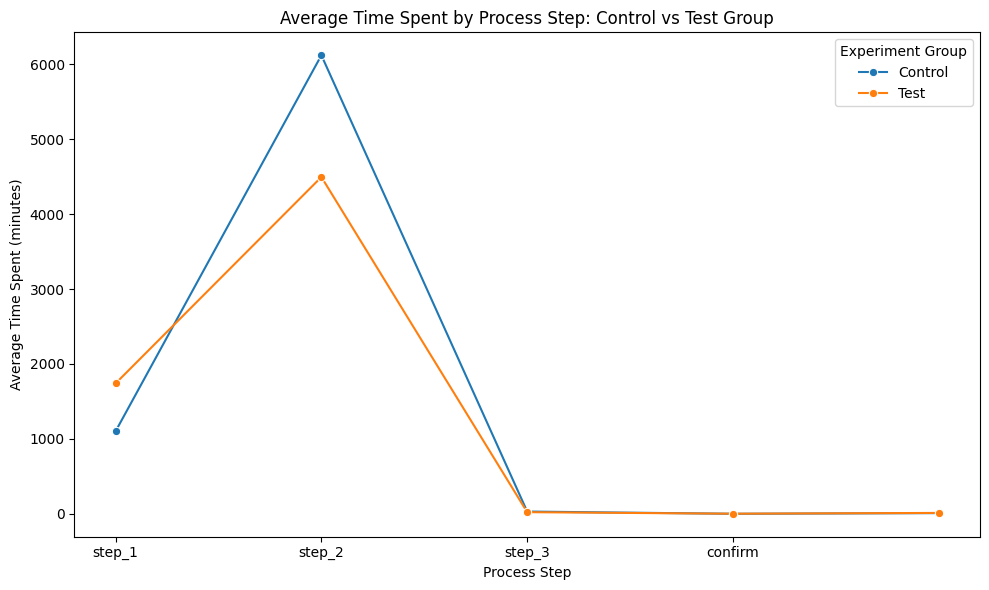

In [38]:
avg_time_spent = pd.DataFrame(design_effectiveness)

# Convert time_spent from seconds to minutes
avg_time_spent['time_spent'] = avg_time_spent['time_spent'] / 60

# Define the order of process steps
order = ['step_1', 'step_2', 'step_3', 'confirm']

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the data using seaborn
sns.lineplot(data=avg_time_spent, x='process_step', y='time_spent', hue='experiment_group', marker='o')

# Add labels and title
plt.xlabel('Process Step')
plt.ylabel('Average Time Spent (minutes)')
plt.title('Average Time Spent by Process Step: Control vs Test Group')
plt.legend(title='Experiment Group')

# Set the order of x-axis
plt.xticks(ticks=range(len(order)), labels=order)

# Show the plot
plt.tight_layout()
plt.show()